# https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/overview/evaluation

# Can you detect fraudulent click traffic for mobile app ads?

In this notebook, we will apply various boosting algorithms to solve an interesting classification problem from the domain of 'digital fraud'.

The analysis is divided into the following sections:
- Understanding the business problem
- Understanding and exploring the data
- Feature engineering: Creating new features
- Model building and evaluation: AdaBoost
- Modelling building and evaluation: Gradient Boosting
- Modelling building and evaluation: XGBoost

## Understanding the Business Problem

<a href="https://www.talkingdata.com/">TalkingData</a> is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download). 

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection">the problem on Kaggle here.</a>.

## Understanding and Exploring the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0). 

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:
- ```ip```: ip address of click.
- ```app```: app id for marketing.
- ```device```: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ```os```: os version id of user mobile phone
- ```channel```: channel id of mobile ad publisher
- ```click_time```: timestamp of click (UTC)
- ```attributed_time```: if user download the app for after clicking an ad, this is the time of the app download
- ```is_attributed```: the target that is to be predicted, indicating the app was downloaded

Let's try finding some useful trends in the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc

%matplotlib inline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

import os
import warnings
warnings.filterwarnings('ignore')

#### Reading the Data  

The code below reads the train_sample.csv file if you set testing = True, else reads the full train.csv file. You can read the sample while tuning the model etc., and then run the model on the full data once done.

#### Important Note: Save memory when the data is huge

Since the training data is quite huge, the program will be quite slow if you don't consciously follow some best practices to save memory. This notebook demonstrates some of those practices. 

In [2]:
# reading training data

# specify column dtypes to save memory (by default pandas reads some columns as floats)
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }

# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

# read training data
train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes, usecols=colnames)

In [3]:
train_sample = pd.read_csv('train_sample.csv')

In [4]:
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [5]:
print(train_sample.memory_usage())

Index                 128
ip                 800000
app                800000
device             800000
os                 800000
channel            800000
click_time         800000
attributed_time    800000
is_attributed      800000
dtype: int64


In [6]:
train_sample.drop('attributed_time',axis=1,inplace=True)

In [7]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  int64 
 1   app            100000 non-null  int64 
 2   device         100000 non-null  int64 
 3   os             100000 non-null  int64 
 4   channel        100000 non-null  int64 
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 5.3+ MB


In [8]:
train_sample.isnull().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

In [9]:
def fraction_unique(x):
    return len(train_sample[x].unique())

number_unique_vals = {x: fraction_unique(x) for x in train_sample.columns}
number_unique_vals

{'ip': 34857,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'is_attributed': 2}

In [10]:
train_sample.dtypes

ip                int64
app               int64
device            int64
os                int64
channel           int64
click_time       object
is_attributed     int64
dtype: object

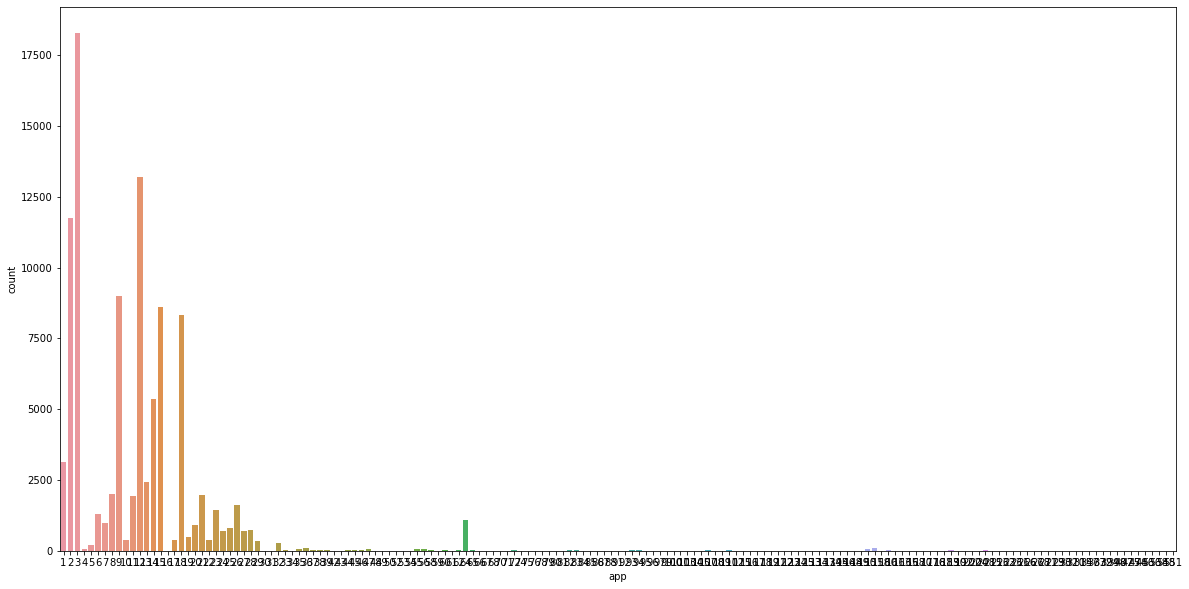

In [11]:
plt.figure(figsize=(20,10))
sns.countplot(x='app',data=train_sample)
plt.show()

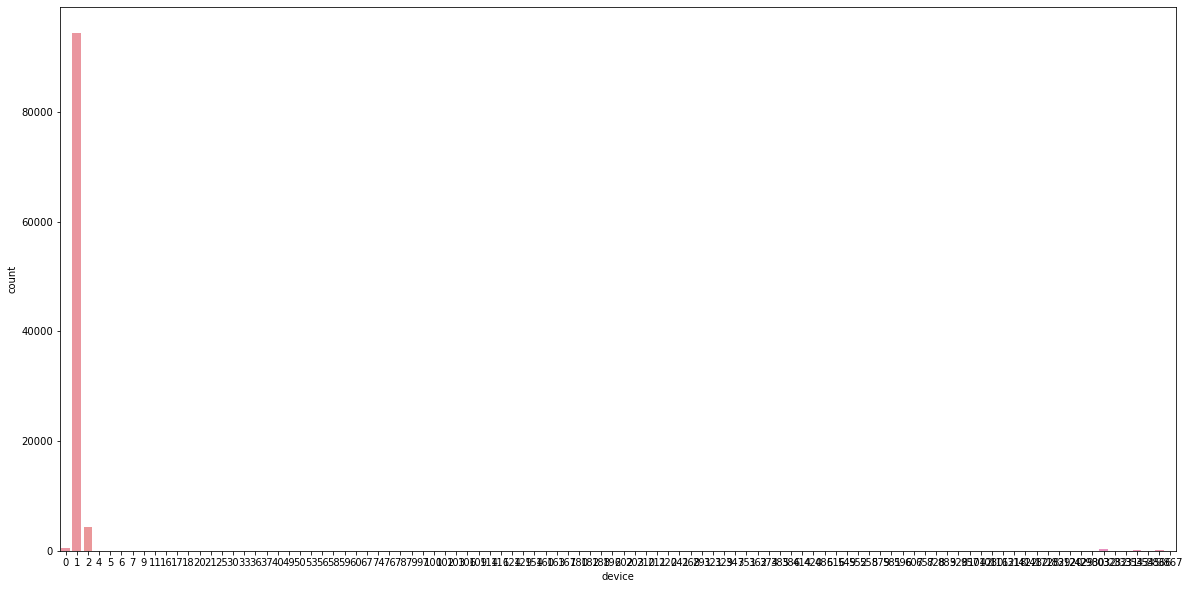

In [12]:
plt.figure(figsize=(20,10))
sns.countplot(x='device',data=train_sample)
plt.show()

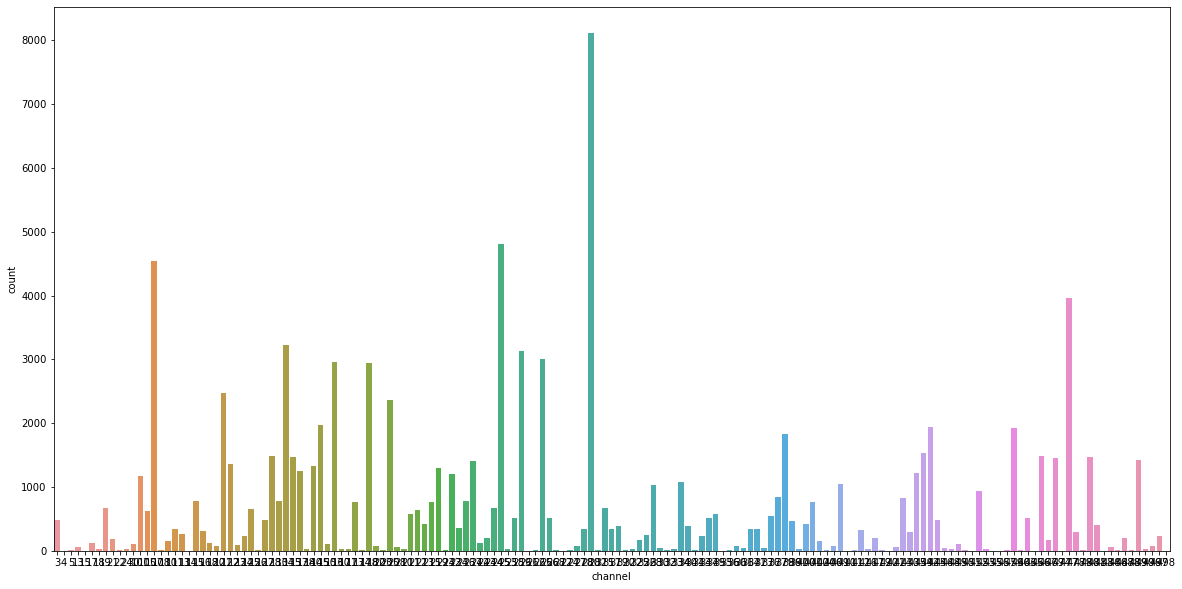

In [13]:
plt.figure(figsize=(20,10))
sns.countplot(x='channel',data=train_sample)
plt.show()

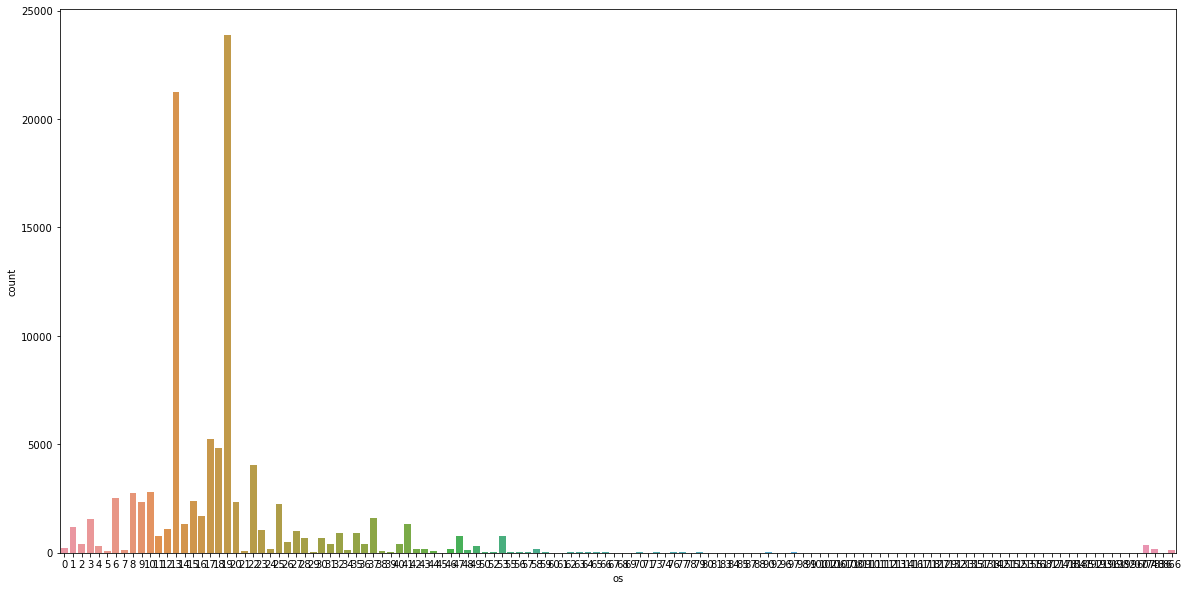

In [14]:
plt.figure(figsize=(20,10))
sns.countplot(x='os',data=train_sample)
plt.show()

In [15]:
100*(train_sample['is_attributed'].value_counts()/len(train_sample.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

##### Only about 0.2% of clicks are 'fraudulent', which is expected in a fraud detection problem. Such high class imbalance is probably going to be the toughest challenge of this problem.

### Exploring the Data - Segmented Univariate Analysis

Let's now look at how the target variable varies with the various predictors.

In [16]:
app_target = train_sample.groupby('app')['is_attributed'].agg(['mean','count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
6,0.000000,1303
7,0.000000,981
8,0.001996,2004
9,0.000890,8992


In [17]:
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps = frequent_apps.merge(train_sample,on='app',how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,89242,1,27,124,2017-11-07 09:37:21,0
3,1,3135,123994,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


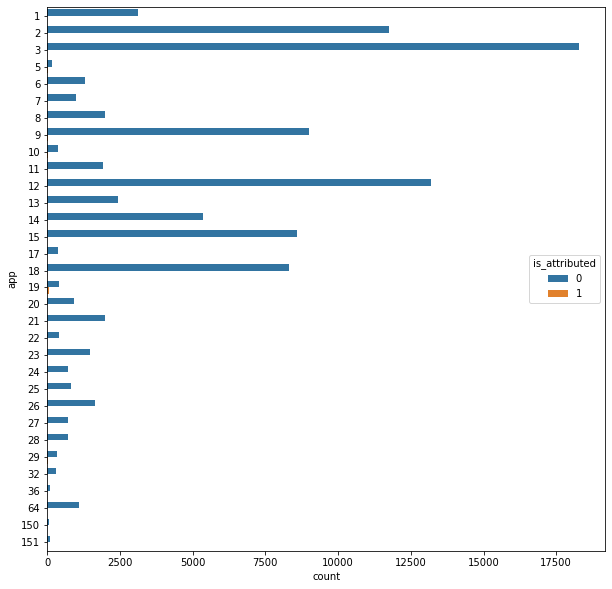

In [18]:
plt.figure(figsize=(10,10))
sns.countplot(y='app',hue='is_attributed',data=frequent_apps)

# Feature Engineering

In [19]:
def timeFeatures(df):
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['month'] = df['datetime'].dt.month
    df['hour'] = df['datetime'].dt.hour
    return df

In [20]:
train_sample = timeFeatures(train_sample)
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed,datetime,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2017-11-07 09:30:38,1,311,11,9
1,105560,25,1,17,259,2017-11-07 13:40:27,0,2017-11-07 13:40:27,1,311,11,13
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2017-11-07 18:05:24,1,311,11,18
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2017-11-07 04:58:08,1,311,11,4
4,68413,12,1,1,178,2017-11-09 09:00:09,0,2017-11-09 09:00:09,3,313,11,9


In [21]:
train_sample.drop(['click_time','datetime'],axis=1,inplace=True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,0,1,311,11,9
1,105560,25,1,17,259,0,1,311,11,13
2,101424,12,1,19,212,0,1,311,11,18
3,94584,13,1,13,477,0,1,311,11,4
4,68413,12,1,1,178,0,3,313,11,9


In [22]:
train_sample.dtypes

ip               int64
app              int64
device           int64
os               int64
channel          int64
is_attributed    int64
day_of_week      int64
day_of_year      int64
month            int64
hour             int64
dtype: object

In [23]:
int_vars = ['ip','app','device','os','channel','is_attributed','day_of_week','day_of_year','month','hour']
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

In [24]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [25]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   is_attributed  100000 non-null  uint16
 6   day_of_week    100000 non-null  uint16
 7   day_of_year    100000 non-null  uint16
 8   month          100000 non-null  uint16
 9   hour           100000 non-null  uint16
dtypes: uint16(10)
memory usage: 1.9 MB


### IP Grouping Based Features

Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

Note that though we are deriving new features by grouping IP addresses, using IP adress itself as a features is not a good idea. This is because (in the test data) if a new IP address is seen, the model will see a new 'category' and will not be able to make predictions (IP is a categorical variable, it has just been encoded with numbers).

In [26]:
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count').astype('int16')
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


In [27]:
# creates groupings of IP addresses with other features and appends the new features to the df
def grouped_features(df):
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip','day_of_week','hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip','hour','channel']].groupby(['ip','hour','channel']).size().reset_index(name='ip_hour_channel')
    ip_hour_os = df.groupby(['ip','hour','os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip','hour','app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip','hour','device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [28]:
train_sample = grouped_features(train_sample)

In [29]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [30]:
gc.collect()

40494

# Modeling

In [31]:
X = train_sample.drop('is_attributed',axis=1)
y = train_sample[['is_attributed']]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((80000, 15), (80000, 1), (20000, 15), (20000, 1))

In [32]:
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


In [33]:
X_train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'day_of_week', 'day_of_year',
       'month', 'hour', 'ip_count', 'ip_day_hour', 'ip_hour_channel',
       'ip_hour_os', 'ip_hour_app', 'ip_hour_device'],
      dtype='object')

In [34]:
y_train.columns

Index(['is_attributed'], dtype='object')

In [35]:
X_train.head()

,ip,app,device,os,channel,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
52529,59065,12,1,41,178,2,312,11,2,2,1,1,1,1,1
73974,23653,3,1,9,173,3,313,11,8,5,1,1,1,1,1
20985,30446,15,1,13,245,2,312,11,15,7,1,1,1,1,1
25914,14345,10,1,13,110,3,313,11,11,66,5,1,2,1,8
77095,7793,3,1,53,379,2,312,11,0,13,2,1,1,1,3


In [36]:
y_train.head()

,is_attributed
52529,0
73974,0
20985,0
25914,0
77095,0


### AdBoost

In [37]:
tree = DecisionTreeClassifier(max_depth=2)
adaboost_model_1 = AdaBoostClassifier(base_estimator=tree,n_estimators=600,learning_rate=1.5,algorithm='SAMME')
adaboost_model_1.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1.5, n_estimators=600)

In [38]:
predictions = adaboost_model_1.predict_proba(X_test)
predictions

array([[0.53957679, 0.46042321],
       [0.5315733 , 0.4684267 ],
       [0.52650365, 0.47349635],
       ...,
       [0.51659029, 0.48340971],
       [0.54333196, 0.45666804],
       [0.53849928, 0.46150072]])

In [39]:
roc_auc_score(y_test,predictions[:,1])

0.9919830730254182

### AdaBoost - Hyperparameter Tuning

Let's now tune the hyperparameters of the AdaBoost classifier. In this case, we have two types of hyperparameters - those of the component trees (max_depth etc.) and those of the ensemble (n_estimators, learning_rate etc.). 


We can tune both using the following technique - the keys of the form ```base_estimator_parameter_name``` belong to the trees (base estimator), and the rest belong to the ensemble.

In [40]:
param_grid = {'base_estimator__max_depth':[2,5],
              'n_estimators':[200,400,600]}

In [41]:
tree = DecisionTreeClassifier()

In [42]:
ABC = AdaBoostClassifier(base_estimator=tree,learning_rate=0.6,algorithm='SAMME')

In [43]:
folds = 3
grid_search_ABC = GridSearchCV(ABC,cv=folds,param_grid=param_grid,scoring='roc_auc',return_train_score=True,verbose=1)

In [44]:
grid_search_ABC.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  7.8min finished


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [45]:
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,7.447473,0.066815,0.358378,0.000940,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.955810,0.907006,0.957901,0.940239,0.023515,1,0.995243,0.996120,0.993311,0.994891,1.173351e-03
1,15.197807,0.328672,0.700133,0.001410,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.958182,0.905549,0.956821,0.940184,0.024497,2,0.997215,0.997490,0.996179,0.996961,5.646103e-04
2,22.579455,0.328235,1.047872,0.003761,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.958777,0.903674,0.954608,0.939020,0.025051,3,0.997872,0.998236,0.997702,0.997937,2.226340e-04
3,15.953125,0.384721,0.408909,0.000814,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.940739,0.918730,0.915246,0.924905,0.011286,4,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,32.080987,0.187107,0.836775,0.021682,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.935919,0.903485,0.920689,0.920031,0.013249,5,1.000000,1.000000,1.000000,1.000000,6.409876e-17
5,48.626869,0.712020,1.263579,0.030446,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.938470,0.899547,0.918888,0.918969,0.015890,6,1.000000,1.000000,1.000000,1.000000,0.000000e+00


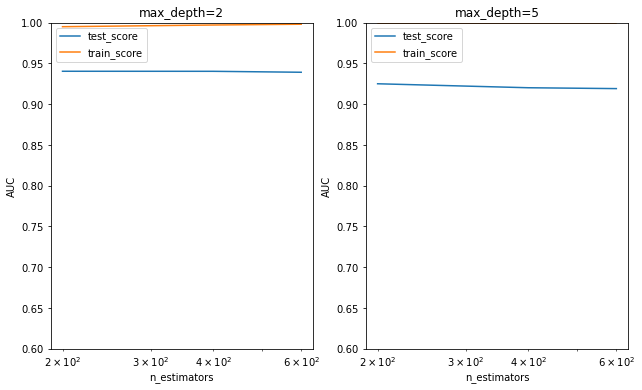

In [46]:
plt.figure(figsize=(16,6))
for n,depth in enumerate(param_grid['base_estimator__max_depth']):
    
    plt.subplot(1,3, n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth']==depth]
    
    plt.plot(depth_df['param_n_estimators'],depth_df['mean_test_score'])
    plt.plot(depth_df['param_n_estimators'],depth_df['mean_train_score'])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title('max_depth={0}'.format(depth))
    plt.ylim([0.60,1])
    plt.legend(['test_score','train_score'],loc='upper left')
    plt.xscale('log')

In [47]:
# model performance on test data with chosen hyperparameters

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

ABC = AdaBoostClassifier(base_estimator=tree,learning_rate=0.6,n_estimators=200,algorithm='SAMME')
ABC.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.6, n_estimators=200)

In [48]:
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.63636826, 0.36363174],
       [0.60518492, 0.39481508],
       [0.59161768, 0.40838232],
       [0.61131948, 0.38868052],
       [0.56378359, 0.43621641],
       [0.60158085, 0.39841915],
       [0.58151491, 0.41848509],
       [0.58033925, 0.41966075],
       [0.63129219, 0.36870781],
       [0.57890563, 0.42109437]])

In [49]:
roc_auc_score(y_test,predictions[:,1])

0.995192516495448

### Gradient Boosting Classifier

Let's now try the gradient boosting classifier. We'll experiment with two main hyperparameters now - ```learning_rate``` (shrinkage) and ```subsample```. 

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between ```learning_rate``` and ```n_estimators``` - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

Also, by subsampling (setting ```subsample``` to less than 1), we can have the individual models built on random subsamples of size ```subsample```. That way, each tree will be trained on different subsets and reduce the model's variance.

In [50]:
param_grid = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
              'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.9]}

In [51]:
GBC = GradientBoostingClassifier(max_depth=2,n_estimators=200)

In [52]:
folds=3
grid_search_GBC = GridSearchCV(GBC,cv=folds,param_grid=param_grid,scoring='roc_auc',return_train_score=True,verbose=1)
grid_search_GBC.fit(X_train,y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  9.4min finished


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=2,
                                                  n_estimators=200),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                         'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [53]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.122173,0.062617,0.033526,0.001073,0.0001,0.1,"{'learning_rate': 0.0001, 'subsample': 0.1}",0.929293,0.860743,0.914215,0.901417,0.029412,12,0.921766,0.916274,0.911015,0.916352,0.004389
1,2.950584,0.038282,0.035882,0.002667,0.0001,0.2,"{'learning_rate': 0.0001, 'subsample': 0.2}",0.911880,0.869451,0.899141,0.893490,0.017776,15,0.900011,0.914500,0.895009,0.903174,0.008265
2,3.704037,0.025376,0.035530,0.002532,0.0001,0.3,"{'learning_rate': 0.0001, 'subsample': 0.3}",0.865916,0.797380,0.857200,0.840165,0.030463,23,0.834806,0.848943,0.847532,0.843761,0.006358
3,4.321576,0.078552,0.035616,0.001755,0.0001,0.4,"{'learning_rate': 0.0001, 'subsample': 0.4}",0.866032,0.806620,0.856374,0.843009,0.026031,19,0.834951,0.861261,0.841788,0.846000,0.011146
4,4.859738,0.027709,0.033896,0.000042,0.0001,0.5,"{'learning_rate': 0.0001, 'subsample': 0.5}",0.865513,0.757928,0.855878,0.826440,0.048604,30,0.834790,0.828815,0.841648,0.835084,0.005243


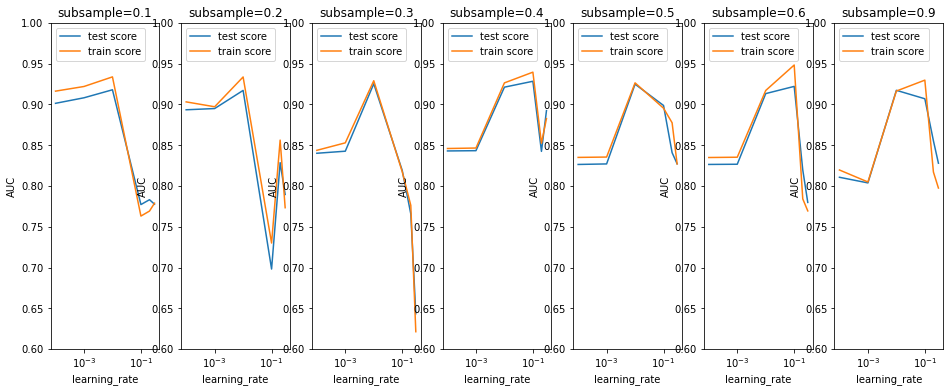

In [54]:
# # plotting
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')


### XGBoost

Let's finally try XGBoost. The hyperparameters are the same, some important ones being ```subsample```, ```learning_rate```, ```max_depth``` etc.

In [55]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.99998152e-01, 1.84246426e-06],
       [9.99988377e-01, 1.16388555e-05],
       [9.99961078e-01, 3.88963017e-05],
       [9.99993861e-01, 6.16532270e-06],
       [9.99192238e-01, 8.07785254e-04],
       [9.99987841e-01, 1.21570547e-05],
       [9.99977648e-01, 2.23480984e-05],
       [9.99856710e-01, 1.43263416e-04],
       [9.99995768e-01, 4.24753989e-06],
       [9.99159575e-01, 8.40434746e-04]], dtype=float32)

In [57]:
roc = roc_auc_score(y_test,y_pred[:,1])
roc

0.9929218519446532

In [58]:
param_grid = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
              'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.9]}

folds = 3

xgb_model = XGBClassifier(max_depth=2,n_estimators=200)

model_cv = GridSearchCV(xgb_model,param_grid=param_grid,scoring='roc_auc',cv=folds,verbose=1,return_train_score=True)

In [59]:
model_cv.fit(X_train,y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  4.2min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [60]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.292646,0.007938,0.030756,0.000229,0.0001,0.1,"{'learning_rate': 0.0001, 'subsample': 0.1}",0.682818,0.754981,0.845592,0.761130,0.066594,42,0.651801,0.826580,0.840089,0.772823,0.085753
1,1.483869,0.072475,0.032940,0.000815,0.0001,0.2,"{'learning_rate': 0.0001, 'subsample': 0.2}",0.866083,0.759137,0.856063,0.827095,0.048227,31,0.835771,0.829041,0.842275,0.835696,0.005403
2,1.611838,0.009825,0.033913,0.001630,0.0001,0.3,"{'learning_rate': 0.0001, 'subsample': 0.3}",0.826456,0.759558,0.855793,0.813936,0.040273,36,0.795568,0.829321,0.841842,0.822244,0.019543
3,1.727656,0.024289,0.033578,0.000939,0.0001,0.4,"{'learning_rate': 0.0001, 'subsample': 0.4}",0.826495,0.759787,0.855817,0.814033,0.040182,34,0.795772,0.829570,0.840818,0.822053,0.019143
4,1.777824,0.011999,0.032913,0.000001,0.0001,0.5,"{'learning_rate': 0.0001, 'subsample': 0.5}",0.826487,0.760155,0.855697,0.814113,0.039974,33,0.795768,0.829699,0.840610,0.822025,0.019094
5,1.819041,0.010458,0.035569,0.002352,0.0001,0.6,"{'learning_rate': 0.0001, 'subsample': 0.6}",0.826498,0.757549,0.856083,0.813377,0.041283,38,0.795786,0.828676,0.840912,0.821791,0.019055
6,1.823840,0.007551,0.034701,0.000925,0.0001,0.9,"{'learning_rate': 0.0001, 'subsample': 0.9}",0.822178,0.755390,0.831489,0.803019,0.033893,41,0.792425,0.826095,0.793294,0.803938,0.015671
7,1.539703,0.038953,0.036099,0.001339,0.001,0.1,"{'learning_rate': 0.001, 'subsample': 0.1}",0.825413,0.754452,0.845982,0.808616,0.039209,40,0.798508,0.826212,0.840082,0.821601,0.017283
8,1.647976,0.020369,0.036892,0.001781,0.001,0.2,"{'learning_rate': 0.001, 'subsample': 0.2}",0.866575,0.759493,0.855812,0.827294,0.048143,29,0.836071,0.829304,0.842108,0.835828,0.005230
9,1.761507,0.013568,0.037471,0.001034,0.001,0.3,"{'learning_rate': 0.001, 'subsample': 0.3}",0.826470,0.759510,0.855854,0.813945,0.040317,35,0.795742,0.829303,0.841892,0.822312,0.019478


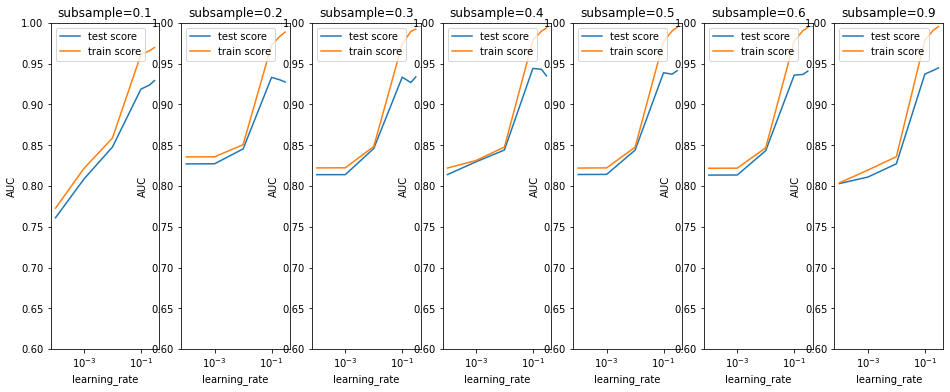

In [61]:
plt.figure(figsize=(16,6))

param_grid = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
              'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.9]}


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [62]:
params = {'learning_rate': 0.1,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

[14:10:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              params={'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [63]:
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.99998152e-01, 1.84246426e-06],
       [9.99988377e-01, 1.16388555e-05],
       [9.99961078e-01, 3.88963017e-05],
       [9.99993861e-01, 6.16532270e-06],
       [9.99192238e-01, 8.07785254e-04],
       [9.99987841e-01, 1.21570547e-05],
       [9.99977648e-01, 2.23480984e-05],
       [9.99856710e-01, 1.43263416e-04],
       [9.99995768e-01, 4.24753989e-06],
       [9.99159575e-01, 8.40434746e-04]], dtype=float32)

In [64]:
auc = roc_auc_score(y_test, y_pred[:, 1])
auc

0.9929218519446532

In [65]:
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'ip': 0.049943443,
 'app': 0.16102782,
 'device': 0.21654655,
 'os': 0.07136472,
 'channel': 0.13406341,
 'day_of_week': 0.049132567,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.051159643,
 'ip_count': 0.08286461,
 'ip_day_hour': 0.053424288,
 'ip_hour_channel': 0.008381763,
 'ip_hour_os': 0.0496577,
 'ip_hour_app': 0.031923722,
 'ip_hour_device': 0.040509827}

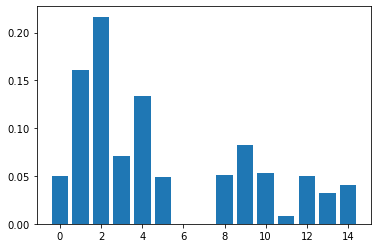

In [66]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

# Predictions on Test Data

In [112]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [113]:
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }

test_final = pd.read_csv('test.csv',dtype=dtypes)
test_final.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,54365,9,1,3,466,2017-11-10 04:00:00
2,2,6751,21,1,19,128,2017-11-10 04:00:00
3,3,12941,15,1,13,111,2017-11-10 04:00:00
4,4,57544,12,1,13,328,2017-11-10 04:00:00


In [114]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   click_id    uint32
 1   ip          uint16
 2   app         uint16
 3   device      uint16
 4   os          uint16
 5   channel     uint16
 6   click_time  object
dtypes: object(1), uint16(5), uint32(1)
memory usage: 394.2+ MB


In [115]:
test_final = timeFeatures(test_final)
test_final.head()

,click_id,ip,app,device,os,channel,click_time,datetime,day_of_week,day_of_year,month,hour
0,0,5744,9,1,3,107,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4
1,1,54365,9,1,3,466,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4
2,2,6751,21,1,19,128,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4
3,3,12941,15,1,13,111,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4
4,4,57544,12,1,13,328,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4


In [116]:
test_final.drop(['click_time','datetime'],axis=1,inplace=True)
test_final.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour
0,0,5744,9,1,3,107,4,314,11,4
1,1,54365,9,1,3,466,4,314,11,4
2,2,6751,21,1,19,128,4,314,11,4
3,3,12941,15,1,13,111,4,314,11,4
4,4,57544,12,1,13,328,4,314,11,4


In [117]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 10 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   click_id     uint32
 1   ip           uint16
 2   app          uint16
 3   device       uint16
 4   os           uint16
 5   channel      uint16
 6   day_of_week  int64 
 7   day_of_year  int64 
 8   month        int64 
 9   hour         int64 
dtypes: int64(4), uint16(5), uint32(1)
memory usage: 824.3 MB


In [118]:
test_final['day_of_week'] = test_final['day_of_week'].astype('uint16')
test_final['day_of_year'] = test_final['day_of_year'].astype('uint16')
test_final['month'] = test_final['month'].astype('uint16')
test_final['hour'] = test_final['hour'].astype('uint16')

In [119]:
X_test.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'day_of_week', 'day_of_year',
       'month', 'hour', 'ip_count', 'ip_day_hour', 'ip_hour_channel',
       'ip_hour_os', 'ip_hour_app', 'ip_hour_device'],
      dtype='object')

In [120]:
test_final.columns

Index(['click_id', 'ip', 'app', 'device', 'os', 'channel', 'day_of_week',
       'day_of_year', 'month', 'hour'],
      dtype='object')

In [121]:
test_final = grouped_features(test_final)

In [122]:
test_final.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,0,5744,9,1,3,107,4,314,11,4,117,34,2,3,8,34
1,1,54365,9,1,3,466,4,314,11,4,2087,403,8,17,50,400
2,2,6751,21,1,19,128,4,314,11,4,2137,229,10,69,13,229
3,3,12941,15,1,13,111,4,314,11,4,1241,240,2,98,10,240
4,4,57544,12,1,13,328,4,314,11,4,218,60,2,27,7,59


In [123]:
test1_final = test_final.drop('click_id',axis=1)

In [124]:
y_pred_test = model.predict_proba(test1_final)

In [125]:
y_pred_test[:10]

array([[9.99744415e-01, 2.55556253e-04],
       [9.99882102e-01, 1.17876254e-04],
       [9.99907732e-01, 9.22778490e-05],
       [9.99443114e-01, 5.56904124e-04],
       [9.99937534e-01, 6.24506647e-05],
       [9.95429277e-01, 4.57074121e-03],
       [9.99675155e-01, 3.24816821e-04],
       [9.99872446e-01, 1.27547013e-04],
       [9.99409258e-01, 5.90751006e-04],
       [9.99932885e-01, 6.71280213e-05]], dtype=float32)

In [126]:
sub = pd.DataFrame()
sub['click_id'] = test_final['click_id']
sub['is_attributed'] = y_pred_test[:,1]
sub.head()

,click_id,is_attributed
0,0,0.000256
1,1,0.000118
2,2,0.000092
3,3,0.000557
4,4,0.000062


In [127]:
sub.to_csv('vikram_sub03.csv',float_format='%.8f',index=False)

In [128]:
dtrain = xgb.DMatrix(X_train,y_train)
del X_train,y_train
gc.collect()

watchlist = [(dtrain,'train')]
model = xgb.train(params,dtrain,30,watchlist,maximize=True,verbose_eval=1)

[14:54:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0.00228
[1]	train-error:0.00228
[2]	train-error:0.00228
[3]	train-error:0.00228
[4]	train-error:0.00228
[5]	train-error:0.00228
[6]	train-error:0.00228
[7]	train-error:0.00228
[8]	train-error:0.00228
[9]	train-error:0.00228
[10]	train-error:0.00228
[11]	train-error:0.00228
[12]	train-error:0.00228
[13]	train-error:0.00228
[14]	train-error:0.00228
[15]	train-error:0.00228
[16]	train-error:0.00228
[17]	train-error:0.00228
[18]	train-error:0.00228
[19]	train-error:0.00228
[20]	train-error:0.00228
[21]	train-error:0.00228
[22]	train-error:0.00228
[23]	train-error:0.00228
[24]	train-error:0.0

In [129]:
del dtrain
gc.collect()

37

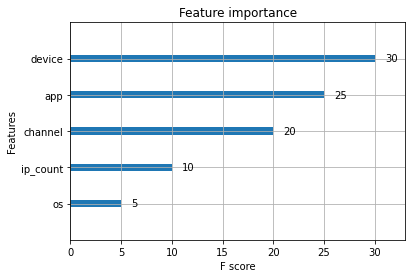

In [130]:
plot_importance(model)
plt.gcf().savefig('featurimportance_xgb.png')

In [131]:
test = pd.read_csv('test.csv')

In [132]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [133]:
ip_count = train_sample.groupby('ip')['channel'].count().reset_index()
ip_count.columns = ['ip', 'count_by_ip']
ip_count.head()

,ip,count_by_ip
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


In [134]:
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
gc.collect()

4366

In [135]:
test = timeFeatures(test)
test.drop(['click_time', 'datetime'], axis=1, inplace=True)
test.head()

,click_id,ip,app,device,os,channel,count_by_ip,day_of_week,day_of_year,month,hour
0,0,5744,9,1,3,107,1.0,4,314,11,4
1,1,119901,9,1,3,466,NaN,4,314,11,4
2,2,72287,21,1,19,128,NaN,4,314,11,4
3,3,78477,15,1,13,111,NaN,4,314,11,4
4,4,123080,12,1,13,328,NaN,4,314,11,4


In [136]:
print(test.columns)
print(train_sample.columns)

Index(['click_id', 'ip', 'app', 'device', 'os', 'channel', 'count_by_ip',
       'day_of_week', 'day_of_year', 'month', 'hour'],
      dtype='object')
Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day_of_week',
       'day_of_year', 'month', 'hour', 'ip_count', 'ip_day_hour',
       'ip_hour_channel', 'ip_hour_os', 'ip_hour_app', 'ip_hour_device'],
      dtype='object')


In [137]:
test = test[['click_id','ip', 'app', 'device', 'os', 'channel', 'day_of_week',
        'day_of_year', 'month', 'hour', 'count_by_ip']]

In [138]:
dtest = xgb.DMatrix(test.drop('click_id', axis=1))

In [140]:
# sub = pd.DataFrame()
# sub['click_id'] = test['click_id']
# sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
# sub.to_csv('xgb_sub.csv', float_format='%.8f', index=False)